# **Portfolio Optimizer**
## **Contents**
1. [Introduction](#Introduction)
2. [Portfolio Metrics](#Portfolio-Metrics)
   - [Portfolio Expected Return](#Portfolio-Expected-Return)
   - [Portfolio Covariance](#Portfolio-Covariance)
   - [Portfolio Variance and Volatility](#Portfolio-Variance-and-Volatility)
   - [Portfolio Sharpe Ratio](#Portfolio-Sharpe-Ratio)
3. [Portfolio Weightings](#Portfolio-Weightings)
   - [Equal-Weighted Portfolio](#Equal-Weighted-Portfolio)
   - [Inverse-Volatility-Weighted Portfolio](#Minimum-Volatility-Portfolio)
   - [Maximum Expected Return Portfolio](#Maximum-Expected-Return-Portfolio)
   - [Minimum Volatility Portfolio](#Minimum-Volatility-Portfolio)
   - [Maximum Sharpe Ratio Portfolio](#Maximum-Sharpe-Ratio-Portfolio)
4. [Efficient Frontier Construction](#Efficient-Frontier-Construction)
   - [Portfolio Simulations](#Portfolio-Simulations)
   - [Minimum Volatility and Maximum Sharpe Ratio Portfolios](#Minimum-Volatility-and-Maximum-Sharpe-Ratio-Portfolios)
5. [Credits](#Credits)

## **Introduction**
This project aims to offer a set portfolio optimization tools for portfolios with risk-bearing financial assets. In particular, several portfolio metrics are defined, as are several different portfolio weightings, where the some of the latter are deduced as solutions to optimization problems. The efficient frontier of portfolios is also introduced and constructed. The `time`, `datetime`, `numpy`, `scipy`, `pandas`, `yfinance`, `matplotlib`, `seaborn` and `warnings` libraries are imported for all the numerical calculations and data analysis/visualisation techniques needed for the purposes of this project. Moreover, a random seed value is set for reproducibility, the plot styles are set for aesthetic reasons and some warnings will be ignored (as those are especially about deprecated features not used in this project at the time of conception). Finally, when optimising the portfolio weightings, the `scipy.optimize.minimize` method is used and the capital bidget and long-only constrants are applied (i.e., all weights in a portfolio must be positive and sum up to one).

In [18]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

np.random.seed(30)
palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_style(style = "whitegrid", rc = {"font.family":"Times New Roman", "font.weight":"bold"})
warnings.simplefilter(action='ignore', category=FutureWarning)

tickers = ["MSFT", "AAPL", "GOOG", "AMZN", "TSLA", "META", "NVDA"]
start_date = "2015-01-01"
end_date = "2020-01-01"
sigma_ast = 0.5
mu_ast = 0.1
freq = 252
risk_free_rate = 0.02
N = 40000

## **Portfolio Metrics**
In a portfolio of assets, there are several specific metrics that can be measured, which also give insight to the performance of the portfolio. In what follows, some of these metrics are defined, using the formalism of probability theory. Moreover, the Python implementation of each of those metrics is also given.

Let $(\Omega, \mathscr{F}, \mathbb{P})$ be a probability space, let $n$ be a non-zero natural number in $\mathbb{N}^{*}$, let $\mathbf{\vec{R}}$ be a $\mathbb{R}_{+}^{n}$-valued random vector on $(\Omega, \mathscr{F}, \mathbb{P})$, and let $\mathbf{\vec{w}}$ be a Euclidean vector in $[0, 1]^{n}$ such that $\sum_{k=1}^{n}w_{k} = 1$. Moreover, consider a portfolio of $n$ risk-bearing assets, having rates of return accodring to the Euclidean vector $\mathbf{\vec{R}}$ and respectively distributed according to the components of the Euclidean vector $\mathbf{\vec{w}}$.

### **Portfolio Expected Return**
- The *rate of return* of the portfolio is the random variable denoted by $R$ and defined by:
$$\forall \omega \in \Omega, \enspace R(\omega) = \mathbf{\vec{w}} \bullet \mathbf{\vec{R}}(\omega) = \sum_{k = 1}^{n}w_{k}\cdot R_{k}(\omega)$$
- The *expected return vector* of the portfolio is the Euclidean vector denoted by $\mathbf{\vec{\mu}}$ and defined by:
$$\mathbf{\vec{\mu}} = \mathbb{E}\left(\mathbf{\vec{R}}\right) = \left(\mathbb{E}(R_{k})\right)_{k=1}^{n}$$
- The *expected rate of return* of the portfolio is the real number denoted by $\mu$ and defined by:
$$\mu = \mathbf{\vec{w}} \bullet \mathbf{\vec{\mu}} = \sum_{k = 1}^{n}w_{k}\cdot \mu_{k} = \sum_{k = 1}^{n}w_{k}\cdot \mathbb{E}(R_{k})$$
The Python implementation of the expected rate of return of a portfolio is given in the code cell below.

In [19]:
def expected_return(tickers, start_date, end_date, weights = None, frequency = 1):
    """
    Computes the expected return of a portfolio of risk-bearing assets using daily historical closing price data

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    weights : list/np.ndarray/None, optional
        An array or list of asset weights for the portfolio. Default : None
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1

    Returns
    -------
    numpy.float64
        A float representing the estimate of the expected return of the portfolio between the start date and the end date.
    """
    n = len(tickers)
    if weights is None:
        weights = np.ones(n) / n
    else:
        pass
    assert type(tickers) is list and len(tickers) > 0
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    expected_returns = returns.mean() * frequency
    portfolio_expected_return = np.dot(weights, expected_returns.T)
    return portfolio_expected_return

expected_return(tickers, start_date, end_date)

0.0012529581026603028

### **Portfolio Covariance**
- The *return covariance* of the portfolio is the matrix denoted by $\mathbf{\Sigma}$ and defined by:
$$\mathbf{\Sigma} = \left[\mathbf{Cov}\left(R_{j}, R_{k}\right)\right]_{(j, k) \in [[ 1, n ]]^{2}}$$
The Python implementation of the return covariance of a portfolio is given in the code cell below.

In [20]:
def covariance(tickers, start_date, end_date):
    """
    Computes the covariance matrix of returns of a portfolio of risk-bearing assets using daily historical closing price data

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period

    Returns
    -------
    numpy.ndarray
        A numpy array representing the covariance matrix of returns of the portfolio between the start date and end date
    """
    assert type(tickers) is list and len(tickers) > 0
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    portfolio_covariance = np.array(returns.cov())
    return portfolio_covariance

covariance(tickers, start_date, end_date)

array([[0.0002448 , 0.00014199, 0.00012337, 0.00012797, 0.00013177,
        0.00018098, 0.00013201],
       [0.00014199, 0.00033951, 0.00017859, 0.00018649, 0.00016935,
        0.00019686, 0.00016241],
       [0.00012337, 0.00017859, 0.00022866, 0.00016112, 0.0001464 ,
        0.00016754, 0.00012381],
       [0.00012797, 0.00018649, 0.00016112, 0.00031599, 0.00013447,
        0.0001783 , 0.00014767],
       [0.00013177, 0.00016935, 0.0001464 , 0.00013447, 0.00021567,
        0.00018524, 0.00012943],
       [0.00018098, 0.00019686, 0.00016754, 0.0001783 , 0.00018524,
        0.00072418, 0.00021197],
       [0.00013201, 0.00016241, 0.00012381, 0.00014767, 0.00012943,
        0.00021197, 0.00080156]])

### **Portfolio Variance and Volatility**
- The *return variance* of the portfolio is the positive real number denoted by $\mathbb{V}\left(R\right)$ and defined by:
$$\mathbb{V}\left(R\right) = \mathbf{\vec{w}} \times \mathbf{\Sigma}\times\mathbf{\vec{w}}^{\mathsf{T}}$$
- The *volatility* of the portfolio is the positive real number denoted by $\sigma\left(R\right)$ and defined by:
$$\sigma\left(R\right) = \sqrt{\mathbb{V}\left(R\right)}$$
The Python implementation of the return variance and the volatility of the portfolio a portfolio is given in the code cells below.

In [21]:
def variance(tickers, start_date, end_date, weights = None, frequency = 1):
    """
    Computes the variance of a portfolio of risk-bearing assets using daily historical closing price data

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    weights : list/np.ndarray/None, optional
        An array or list of asset weights for the portfolio. Default : None
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1
    
    Returns
    -------
    numpy.float64
        A numpy float representing the variance of the portfolio between the start date and end date
    """
    n = len(tickers)
    if weights is None:
        weights = np.ones(n) / n
    else:
        pass
    assert type(tickers) is list and len(tickers) > 0
    portfolio_covariance = covariance(tickers, start_date, end_date)
    portfolio_variance = np.dot(np.dot(weights, portfolio_covariance), weights.T) * frequency
    return portfolio_variance

variance(tickers, start_date, end_date)

0.0001939971904098951

In [22]:
def volatility(tickers, start_date, end_date, weights = None, frequency = 1):
    return np.sqrt(variance(tickers, start_date, end_date, weights, frequency))

volatility(tickers, start_date, end_date)

0.013928287418412039

### **Portfolio Sharpe Ratio**
Let $(r, \rho)$ be an ordered pair of strictly positive real numbers in $\mathbb{R}_{+}^{\ast} \times ]0, 1[$, suppose that the portfolio contains, in addition to the $n$ original risk-bearing assets, one riskless asset with rate of return $r$ and having proportion $\rho$ in the portfolio distribution of assets and let $\mathbf{\vec{v}}$ be the Euclidean vector representing the newly constructed portfolio's distribution of assets, defined by:
$$\mathbf{\vec{v}} = \left(\left(1 - \rho\right) \cdot w_{1}, \left(1 - \rho\right) \cdot w_{2}, \dots, \left(1 - \rho\right) \cdot w_{n}, \rho\right)$$
- The *Sharpe ratio* of the newly-constructed portfolio is the positive real number denoted by $\mathrm{Sharpe}\left(R, r\right)$ and defined by:
$$\mathrm{Sharpe}\left(R, r\right) = \frac{\mathbb{E}\left(R - r\right)}{\sigma\left(R\right)}$$
The Python implementation of the Sharpe ratio of a portfolio and a riskless asset is given in the code cell below.

In [23]:
def sharpe_ratio(tickers, start_date, end_date, weights = None, frequency = 1, risk_free_rate = 0.02):
    """
    Computes the Sharpe ratio of a portfolio of risk-bearing assets using daily historical closing price data and a stipulated risk-free interest rate

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    weights : list/np.ndarray/None, optional
        An array or list of asset weights for the portfolio. Default : None
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1
    risk_free_rate : int/float, optional
        The risk-free interest rate to calculate the Sharpe ratio. Default : 0.02
    
    Returns
    -------
    numpy.float64
        A numpy float representing the Sharpe ratio of the portfolio between the start date and end date
    """
    n = len(tickers)
    if weights is None:
        weights = np.ones(n) / n
    else:
        pass
    assert type(tickers) is list and len(tickers) > 0
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    portfolio_returns = returns.dot(weights)
    adjusted_portfolio_returns = portfolio_returns * frequency
    adjusted_risk_free_rate = risk_free_rate * frequency
    excess_returns = adjusted_portfolio_returns - adjusted_risk_free_rate
    expected_excess_return = excess_returns.mean()
    volatility = adjusted_portfolio_returns.std()
    portfolio_sharpe_ratio = expected_excess_return / volatility
    return portfolio_sharpe_ratio

sharpe_ratio(tickers, start_date, end_date)

-1.3459689144953784

## **Portfolio Weightings**
Given the Euclidean vector $\mathbf{\vec{R}}$ of rates of returns of the risky assets in the portfolio, as well as the Euclidean vector $\mathbf{\vec{w}}$ of weights in the distribution of assets in the portfolio, completely determine the expected return $\mu$ and the volatility $\sigma$ of the portfolio. By extension, they also uniquely determines the Sharpe ratio $\mathrm{Sharpe}(R, r)$ of the portfolio. Given the Euclidean vector $\mathbf{R}$, it is often desirable to select the value of the Euclidean vector $\mathbf{\vec{w}}$ in such a way that $\mu$ is as high as possible, or that $\sigma$ is as low as possible, pending certain conditions being satisfied. That is, it is desirable to select the value of the Euclidean vector $\mathbf{\vec{w}}$ which solves specific optimization problems in $\mathbf{\vec{w}}$, which are expressed in terms of $\mathbf{\vec{w}}$, $\mathbf{\Sigma}$, $\mu$, $\sigma$, and/or $r$. Such selections are *portfolio weightings* (or *portfolio allocations*, or *asset allocations*), of which several stand out.

### **Equal-Weighted Portfolio**
The equal-weighted portfolio is the portfolio wherein all components of the Euclidean vector $\mathbf{\vec{w}}$ are equal:
$$\mathbf{\vec{w}} = \left(\frac{1}{n}\right)_{k = 1}^{n}$$
The Python implementation for constructing an equal-weighted portfolio is given in the code cell below.

In [24]:
def equal_weighted(tickers, start_date = None, end_date = None):
    """
    Computes the weights of the equal-weighted portfolio of a list of risk-bearing assets

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime/None
        The start date of the lookback period. Default : None
    end_date : str/datetime.datetime/None
        The end date of the lookback period. Default : None
    
    Returns
    -------
    numpy.ndarray
        A numpy array representing the weights of the equal-weighted portfolio of the assets
    """
    assert type(tickers) is list and len(tickers) > 0
    n = len(tickers)
    w = np.ones(n) / n
    return w

equal_weighted(tickers, start_date, end_date)

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

### **Inverse-Volatility-Weighted Portfolio**
The inverse-volatility-weighted portfolio is the portfolio wherein the components of the Euclidean vector $\mathbf{\vec{w}}$ are inversely proportional to their corresponding asset volatilities:
$$\left(\forall k \in [[ 1, n ]], \enspace \sigma_{k} = \sigma\left(R_{k}\right)\right) \implies \mathbf{\vec{w}} = \left(\dfrac{\frac{1}{\sigma_{k}}}{\sum_{j=1}^{n}\frac{1}{\sigma_{j}}}\right)_{k = 1}^{n}$$
The Python implementation for constructing an inverse-volatility-weighted portfolio is given in the code cell below.

In [25]:
def inverse_volatility_weighted(tickers, start_date, end_date):
    """
    Computes the weights of the inverse-volatility-weighted portfolio of a list of risk-bearing assets

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    
    Returns
    -------
    numpy.ndarray
        A numpy array representing the weights of the inverse-volatility-weighted portfolio of the assets
    """
    assert type(tickers) is list and len(tickers) > 0
    data = yf.download(tickers, start_date, end_date, progress = False)
    S = data["Adj Close"]
    R = S.pct_change()
    sigma = R.std()
    I = np.divide(1, sigma)
    w = np.array(np.divide(I, np.sum(I)))
    return w

inverse_volatility_weighted(tickers, start_date, end_date)

array([0.16768894, 0.14239107, 0.17350475, 0.14759491, 0.17865362,
       0.09749602, 0.09267069])

### **Maximum Expected Return Portfolio**
The maximum expected return portfolio is the portfolio wherein the Euclidean vector $\mathbf{\vec{w}}$ maximizes the value of the expected return $\mu$ subject to an upper bound $\sigma_{\ast}$ on $\sigma$, that is, the Euclidean vector $\mathbf{\vec{w}}$ satisfies:
$$\mathbf{\vec{w}} \in \displaystyle \mathrm{argmax}_{\substack{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \\ \sigma(\mathbf{\vec{x}}) \leqslant \sigma_{\ast} \\ \sum_{k=1}^{n}x_{k} = 1}}\left(\mu\left(\mathbf{\vec{x}}\right)\right)$$
where $\mu$ is the function defined by:
$$\begin{array}{c|ccc} \mu \colon  &   \left\{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \colon \enspace \sum_{k=1}^{n}x_{k} = 1\right\}    &   \longrightarrow &   \mathbb{R} \\
&   \mathbf{\vec{w}}                                                                                    &   \longmapsto     &   \mathbf{\vec{w}} \bullet \mathbf{\vec{\mu}}
\end{array}$$
or, equivalently, solves the following quadratic program:
\begin{align*}
\textrm{maximize}   \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{\mu}}                                                 \\
\textrm{subject to} \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}} \leqslant \sigma_{\ast}^2, \\
                            &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{1}} = 1,                                              \\
                            &   \mathbf{\vec{w}} \geqslant \mathbf{\vec{0}}
\end{align*}
Given the long-only constraint (i.e., all components of the Euclidean vector $\mathbf{\vec{w}}$ are positive), this quadratic program has no known closed-form solution, and should therefore be solved numerically. The Python implementation for constructing a maximum expected return portfolio is given in the code cell below.

In [26]:
def maximum_expected_return_weighted(tickers, start_date, end_date, sigma_ast, frequency = 1):
    """
    Computes the weights of a maximum-expected-return-weighted portfolio of a list of risk-bearing assets, not exceeding a stipulated volatility threshold

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    sigma_ast : int/float
        The volatility threshold for the portfolio
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1
    
    Returns
    -------
    numpy.ndarray
        A numpy array representing the weights of the maximum-expected-return-weighted portfolio of the assets
    """
    n = len(tickers)
    def objective(w):
        return -expected_return(tickers, start_date, end_date, w, frequency)
    constraints = (
        {"type" : "ineq", "fun" : lambda v: sigma_ast**2 - variance(tickers, start_date, end_date, v, frequency)},
        {"type" : "eq", "fun" : lambda v: np.sum(v) - 1},
        {"type" : "ineq", "fun" : lambda v: np.min(v)}
        )
    bounds = n * ((0, 1),)
    initial_guess = np.divide(np.ones(n), n)
    result = sp.optimize.minimize(objective, initial_guess, bounds = bounds, constraints = constraints, method = "SLSQP")
    return result.x

maximum_expected_return_weighted(tickers, start_date, end_date, sigma_ast, freq)

array([1.58147664e-15, 0.00000000e+00, 1.61103714e-15, 9.85466982e-16,
       5.23539365e-16, 1.00000000e+00, 0.00000000e+00])

### **Minimum Volatility Portfolio**
The minimum volatility portfolio is the portfolio wherein the Euclidean vector $\mathbf{\vec{w}}$ minimizes the value of the volatility $\sigma$ subject to a lower bound $\mu_{\ast}$ on $\mu$, that is, the Euclidean vector $\mathbf{\vec{w}}$ satisfies:
$$\mathbf{\vec{w}} \in \displaystyle \mathrm{argmin}_{\substack{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \\ \mu(\mathbf{\vec{x}}) \geqslant \mu_{\ast} \\ \sum_{k=1}^{n}x_{k} = 1}}\left(\sigma\left(\mathbf{\vec{x}}\right)\right)$$
where $\sigma$ is the function defined by:
$$\begin{array}{c|ccc} 
\sigma \colon   &   \left\{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \colon \enspace \sum_{k=1}^{n}x_{k} = 1\right\}   &   \longrightarrow &   \mathbb{R} \\
                &   \mathbf{\vec{w}}                                                                                    &   \longmapsto     &   \sqrt{\mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}}}
\end{array}$$
or, equivalently, solves the following quadratic program:
\begin{align*}
\textrm{minimize}   \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}}    \\
\textrm{subject to} \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{\mu}} \geqslant \mu_{\ast},   \\
                            &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{1}} = 1,                      \\
                            &   \mathbf{\vec{w}} \geqslant \mathbf{\vec{0}}
\end{align*}
Given the long-only constraint (i.e., all components of the Euclidean vector $\mathbf{\vec{w}}$ are positive), this quadratic program has no known closed-form solution, and should therefore be solved numerically. The Python implementation for constructing the minimum volatility portfolio is given in the code cell below.

In [27]:
def minimum_volatility_weighted(tickers, start_date, end_date, mu_ast, frequency = 1):
    """
    Computes the weights of a minimum-volatility-weighted portfolio of a list of risk-bearing assets, not falling below a stipulated expected return threshold

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    mu_ast : int/float
        The expected return threshold for the portfolio
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1
    
    Returns
    -------
    numpy.ndarray
        A numpy array representing the weights of the maximum-expected-return-weighted portfolio of the assets
    """
    n = len(tickers)
    def objective(w):
        return variance(tickers, start_date, end_date, w, frequency)
    constraints = (
        {"type" : "ineq", "fun" : lambda v: expected_return(tickers, start_date, end_date, v, frequency) - mu_ast},
        {"type" : "eq", "fun" : lambda v: np.sum(v) - 1},
        {"type" : "ineq", "fun" : lambda v: np.min(v)},
    )
    bounds = n * ((0, 1),)
    initial_guess = np.divide(np.ones(n), n)
    result = sp.optimize.minimize(objective, initial_guess, bounds = bounds, constraints = constraints, method = "SLSQP")
    return result.x

minimum_volatility_weighted(tickers, start_date, end_date, mu_ast, freq)

array([0.28276459, 0.        , 0.25224019, 0.11639157, 0.30191999,
       0.        , 0.04668366])

### **Maximum Sharpe Ratio Portfolio**
The maximum Sharpe Ratio portfolio is the portfolio wherein the Euclidean vector $\mathbf{\vec{w}}$ maximizes the value of the Sharpe ratio $\mathrm{Sharpe}(R, r)$, that is, the Euclidean vector $\mathbf{\vec{w}}$ satisfies:
$$\mathbf{\vec{w}} \in \displaystyle \mathrm{argmax}_{\substack{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \\ \sum_{k=1}^{n}x_{k} = 1}}\left(\mathrm{Sharpe}\left(R\left(\mathbf{\vec{x}}\right), r\right)\right)$$
where $R$ is the function defined by:
$$\begin{array}{c|ccc} R \colon  &   \left\{\mathbf{\vec{x}} \in \left[0, 1\right]^{n} \colon \enspace \sum_{k=1}^{n}x_{k} = 1\right\}    &   \longrightarrow &   \mathrm{L}^{1}\left(\Omega,\mathscr{F},\mathbb{P}\right) \\
&   \mathbf{\vec{w}}                                                                                    &   \longmapsto     &   \mathbf{\vec{w}} \bullet \mathbf{\vec{R}}
\end{array}$$
or, equivalently, solves the following program:
\begin{align*}
\textrm{maximize}   \quad   &   \frac{\mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{\mu}} - r}{\sqrt{\mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\Sigma} \times \mathbf{\vec{w}}}} \\
\textrm{subject to} \quad   &   \mathbf{\vec{w}}^{\mathsf{T}} \times \mathbf{\vec{1}} = 1,  \\
                            &   \mathbf{\vec{w}} \geqslant \mathbf{\vec{0}}
\end{align*}
Given the long-only constraint (i.e., all components of the Euclidean vector $\mathbf{\vec{w}}$ are positive), this quadratic program has no known closed-form solution, and should therefore be solved numerically. The Python implementation for constructing the maximum Sharpe ratio portfolio is given in the code cell below.

In [28]:
def maximum_sharpe_ratio_weighted(tickers, start_date, end_date, risk_free_rate = 0.02, frequency = 1):
    """
    Computes the weights of a maximum-sharpe-ratio-weighted portfolio of a list of risk-bearing assets, given a stipulated risk-free interest rate

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    risk_free_rate : int/float, optional
        The risk-free interest rate to calculate the Sharpe ratio. Default : 0.02
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1
    
    Returns
    -------
    numpy.ndarray
        A numpy array representing the weights of the maximum-sharpe-ratio-weighted portfolio of the assets
    """
    n = len(tickers)
    def objective(w):
        return -1 * sharpe_ratio(tickers, start_date, end_date, w, frequency, risk_free_rate)
    constraints = (
        {"type" : "eq", "fun" : lambda v: np.sum(v) - 1},
        {"type" : "ineq", "fun" : lambda v: np.min(v)},
    )
    bounds = n * ((0, 1),)
    initial_guess = np.divide(np.ones(n), n)
    result = sp.optimize.minimize(objective, initial_guess, bounds = bounds, constraints = constraints, method = "SLSQP")
    return result.x

maximum_sharpe_ratio_weighted(tickers, start_date, end_date, risk_free_rate, freq)

array([0.00000000e+00, 3.28639103e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.77635684e-15])

## **Efficient Frontier Construction**

### **Portfolio Simulations**
Roughly speaking, the *efficient frontier* of a list of assets is the set of all volatility-expected return pairs generated from all possible portfolios of the assets, which yield the most optimal tradeoff. More rigorously, it is the set of all risk-return pairs generated by portfolios with the greatest return for a fixed level of risk. The Python implementation of the visualisation of the efficient frontier is given in the code cell below.

In [29]:
def efficient_frontier(tickers, start_date, end_date, risk_free_rate = 0.02, frequency = 1, iterations = 1):
    """
    Computes the volatilities, expected returns and Sharpe ratios of simulated portfolios

    Parameters
    ----------
    tickers : list
        A list of tickers of all of the assets in the portfolio
    start_date : str/datetime.datetime
        The start date of the lookback period
    end_date : str/datetime.datetime
        The end date of the lookback period
    risk_free_rate : int/float, optional
        The risk-free interest rate to calculate the Sharpe ratio. Default : 0.02
    frequency : int, optional
        The frequency of observations of price data between the start date and end date (in days). Default : 1
    iterations : int, optional
        The number of portfolios to simulate
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A pandas DataFrame representing the table of volatilities, expected returns and Sharpe ratios of the simulated portfolios
    """
    assert type(tickers) is list and len(tickers) > 0
    n = len(tickers)
    prices = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Adj Close"]
    returns = prices.pct_change()
    Mu = returns.mean() * frequency
    Sigma = returns.cov() * frequency
    x = np.random.random(size = (iterations, n))
    S = np.sum(x, axis = 1)
    w = x / S.reshape((iterations, 1))
    expected_returns = np.dot(w, Mu)
    variances = np.diag(np.matmul(np.matmul(w, Sigma), w.T))
    volatilities = np.sqrt(variances)
    sharpe_ratios = (expected_returns - risk_free_rate) / volatilities
    ef = pd.DataFrame({
        "Volatilities" : volatilities,
        "Expected Returns" : expected_returns,
        "Sharpe Ratios" : sharpe_ratios
    })
    return ef

EF = efficient_frontier(tickers, start_date, end_date, risk_free_rate, freq, N)
EF.head()

,Volatilities,Expected Returns,Sharpe Ratios
0,0.224565,0.290799,1.205880
1,0.237153,0.330239,1.308178
2,0.222394,0.269681,1.122698
3,0.225799,0.327977,1.363942
4,0.224133,0.319664,1.336992


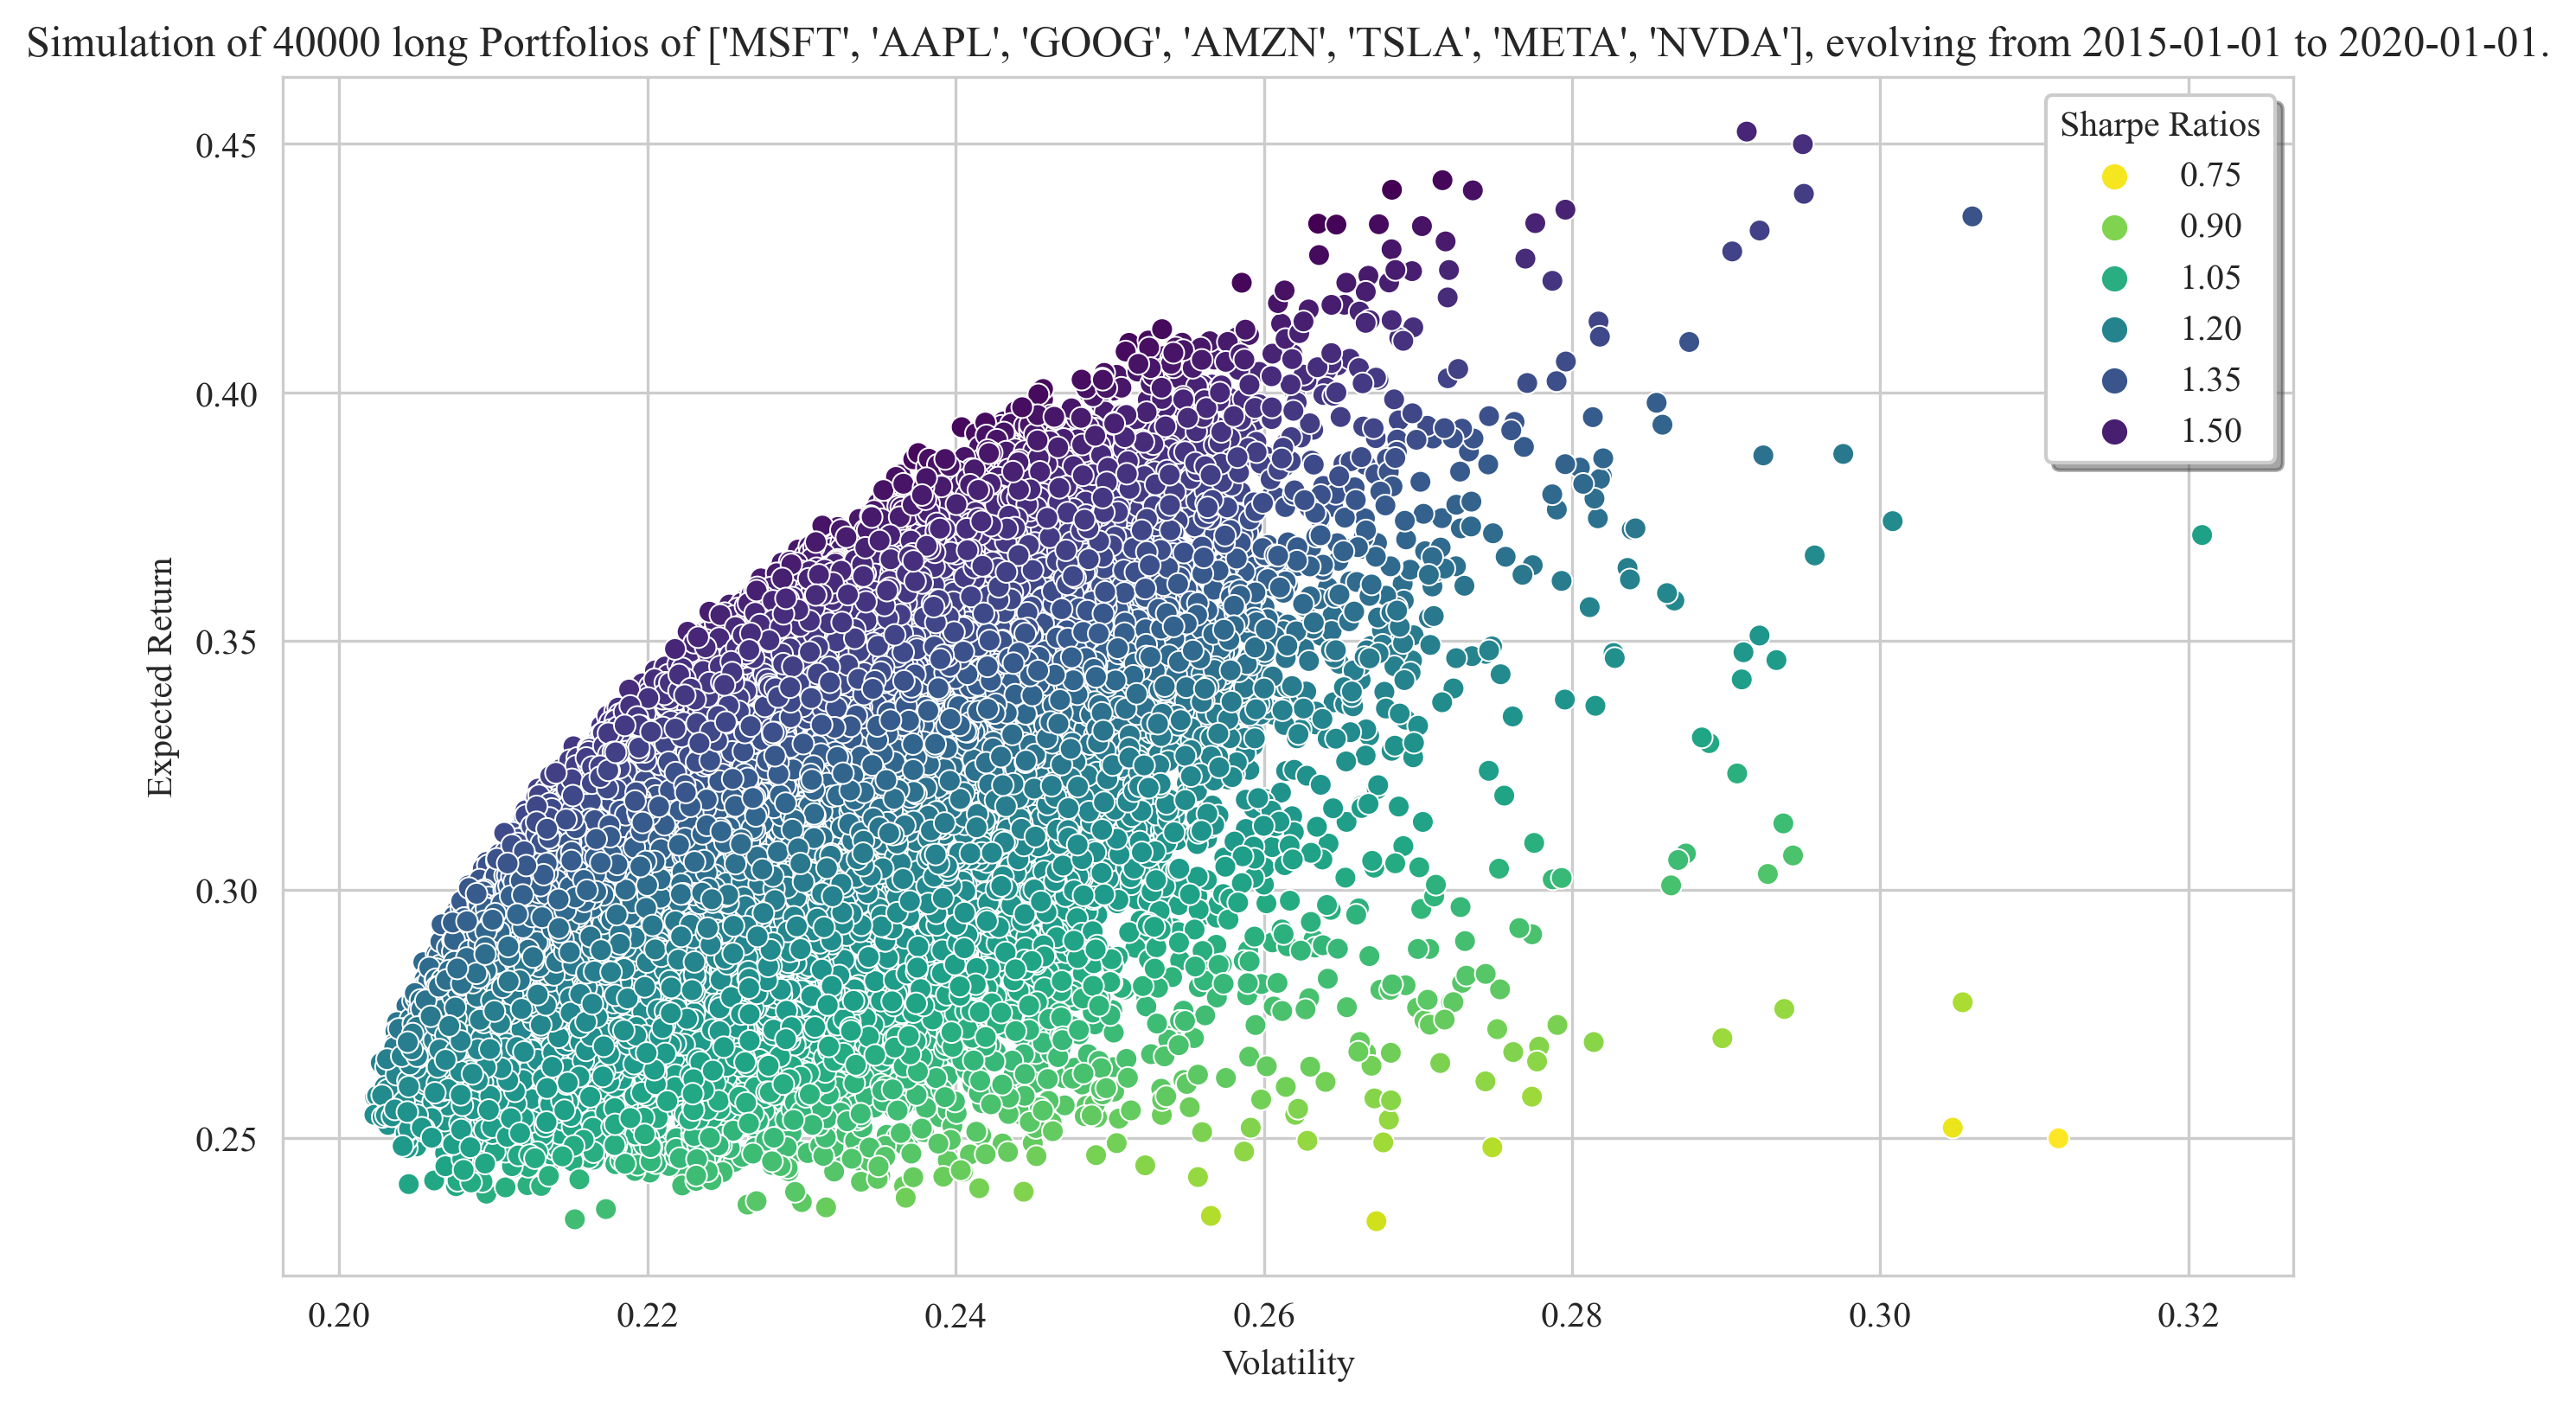

In [30]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
sns.scatterplot(data = EF, x = "Volatilities", y = "Expected Returns", hue = "Sharpe Ratios", palette = palette)
ax.set(xlabel = "Volatility", ylabel = "Expected Return", title = f"Simulation of {N} long Portfolios of {tickers}, evolving from {start_date} to {end_date}.")
plt.legend(title="Sharpe Ratios", loc="upper right", shadow=True)
plt.show()

The efficient frontier is approximately equal to the boundary of the convex hull of these points.

### **Maximum Sharpe Ratio and Minimum Volatility Portfolios**
One can add an estimate of the risk-return pair corresponding to the Maximum Sharpe Ratio and Minimum Volatility portfolios to the previous plot. The Python implementation of this is given in the code cell below.

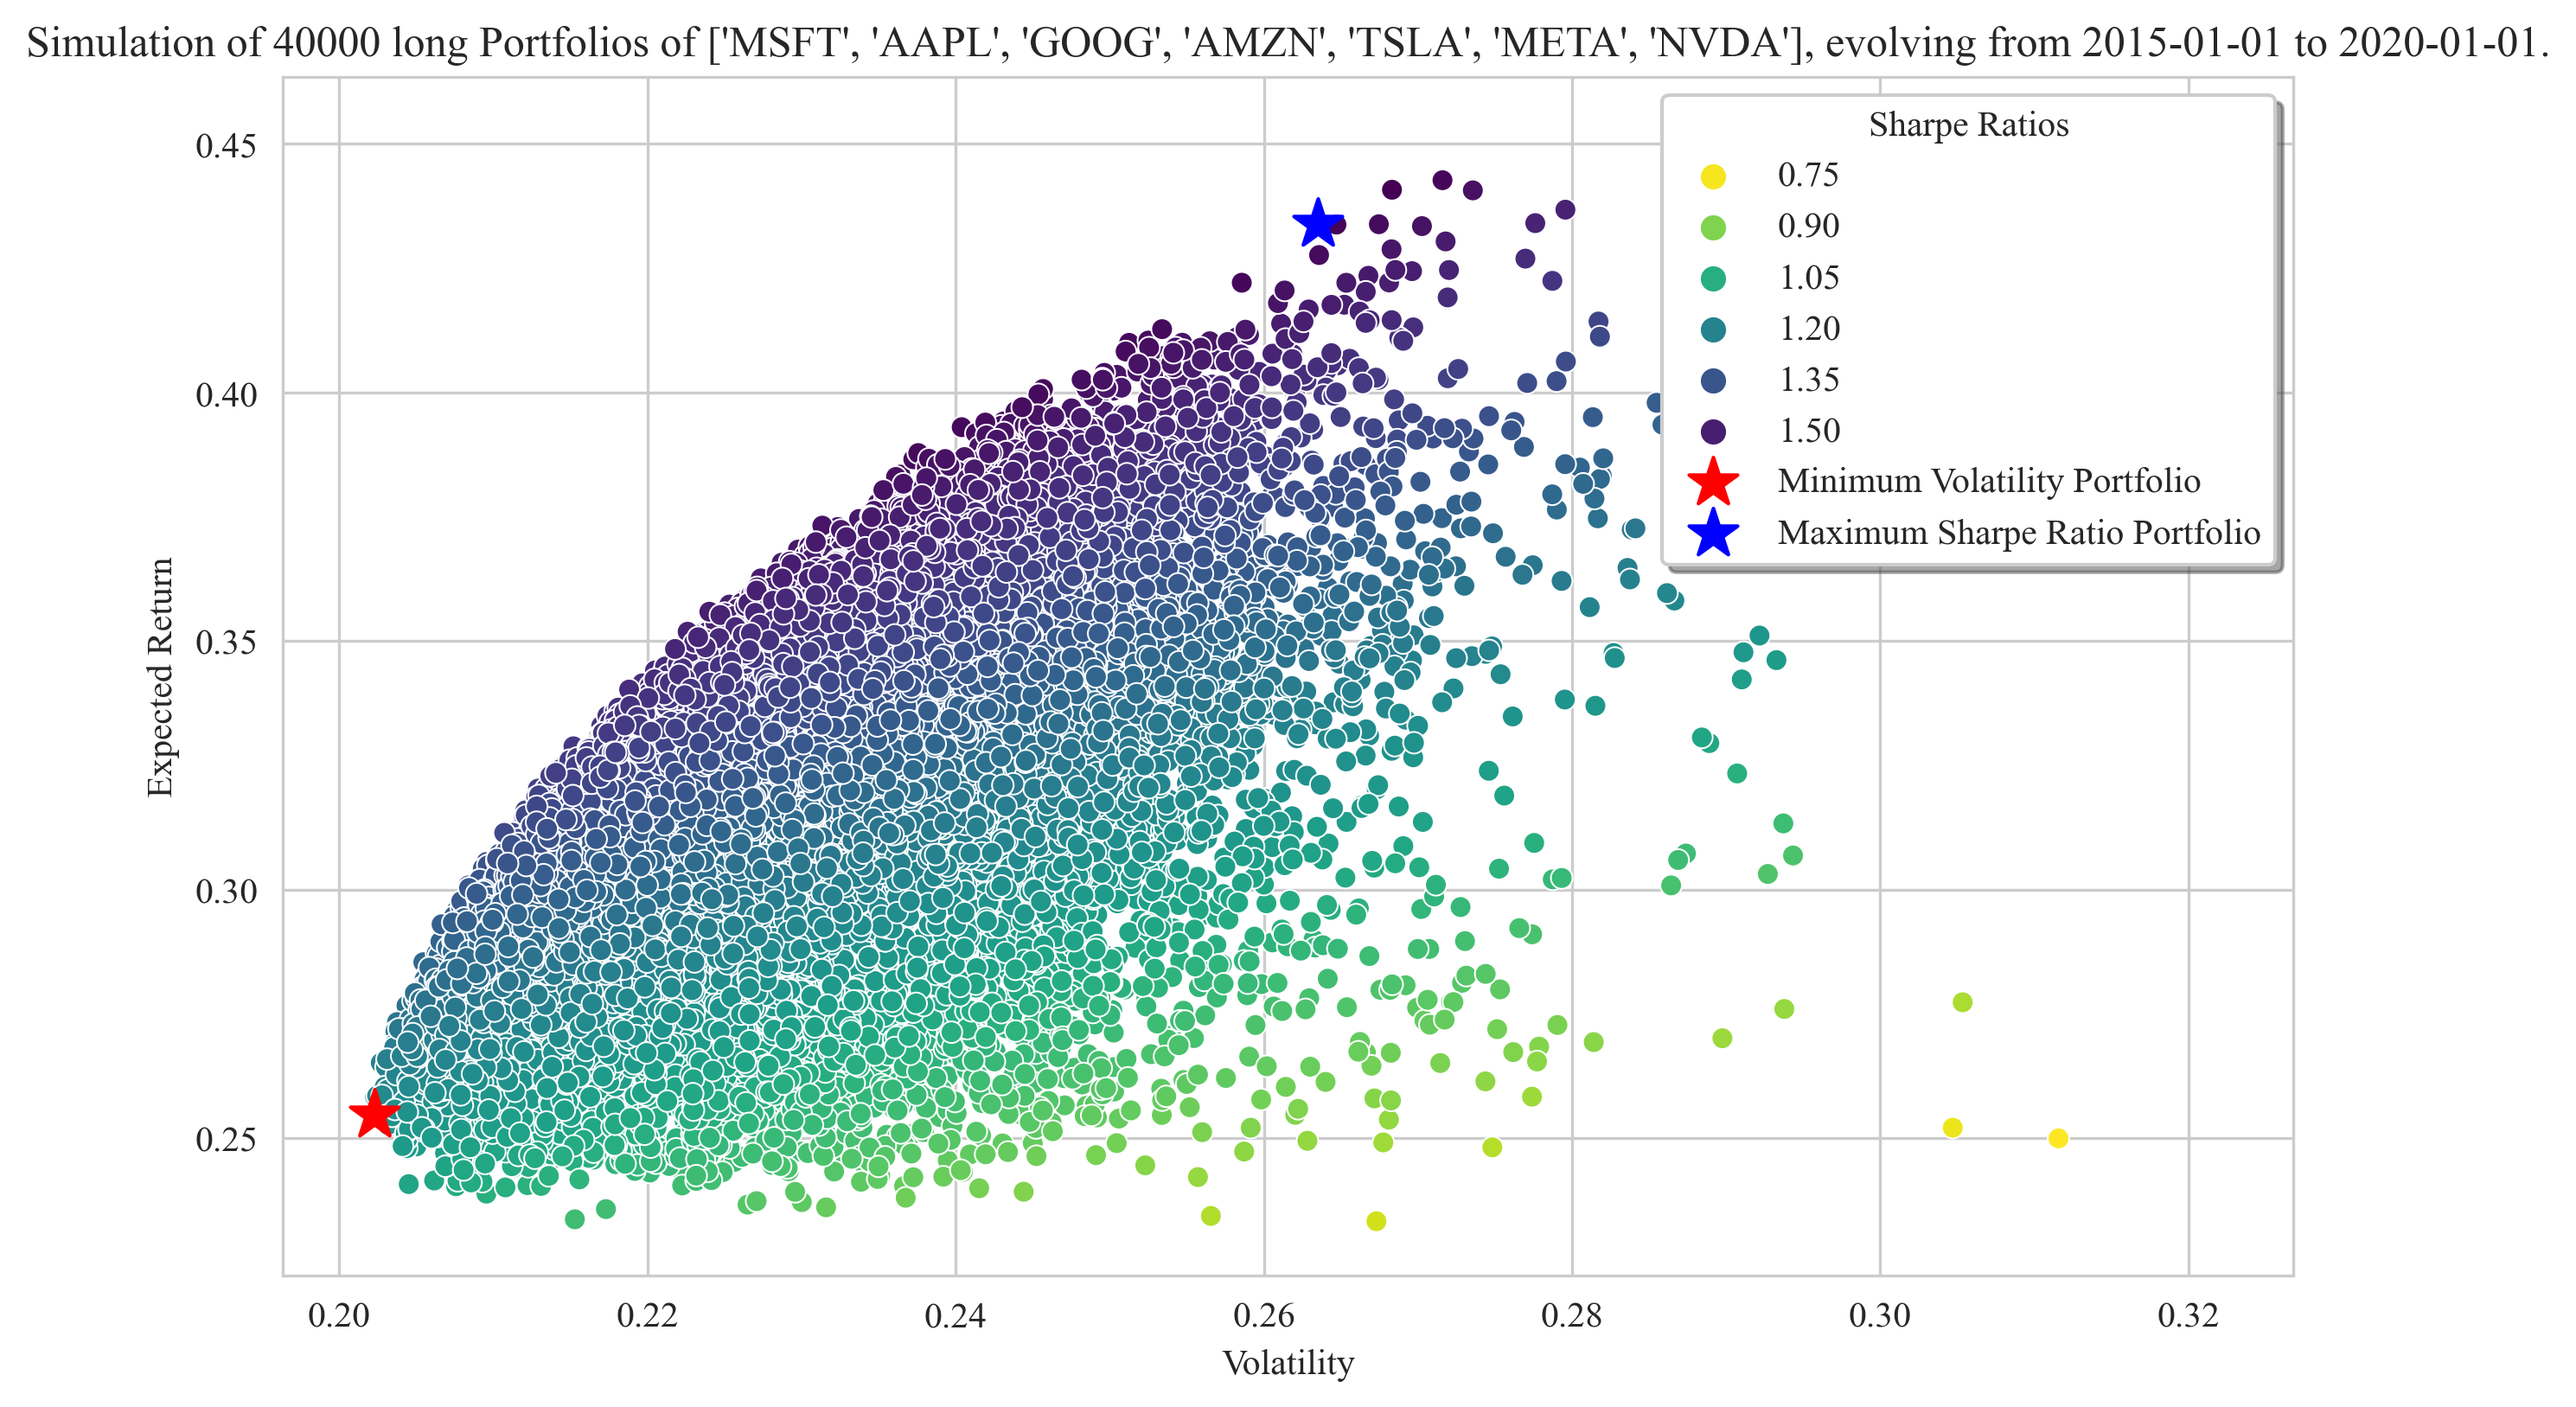

In [31]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 300)
sns.scatterplot(data = EF, x = "Volatilities", y = "Expected Returns", hue = "Sharpe Ratios", palette = palette)
ax.set(xlabel = "Volatility", ylabel = "Expected Return", title = f"Simulation of {N} long Portfolios of {tickers}, evolving from {start_date} to {end_date}.")
x_MSR = EF.iloc[EF["Sharpe Ratios"].idxmax()][[0, 1]]
x_MV = EF.iloc[EF["Volatilities"].idxmin()][[0, 1]]
plt.scatter(x_MV[0], x_MV[1], label = "Minimum Volatility Portfolio", marker = "*", color = "red", s = 200)
plt.scatter(x_MSR[0], x_MSR[1], label = "Maximum Sharpe Ratio Portfolio", marker = "*", color = "blue", s = 200)
plt.legend(title="Sharpe Ratios", loc="upper right", shadow=True)
plt.show()

## **Credits**
- Virtanen, P., Gommers, R., Oliphant, T.E. et al. "[SciPy 1.0: fundamental algorithms for scientific computing in Python](https://doi.org/10.1038/s41592-019-0686-2)" Nat Methods 17, 261–272 (2020).
- Martin, R. A. "[PyPortfolioOpt: portfolio optimization in Python](https://doi.org/10.21105/joss.03066)" Journal of Open Source Software, 6(61), 3066 (2021)
- Palomar, Danial P. "[Portfolio Optimization](https://palomar.home.ece.ust.hk/ELEC5470_lectures/slides_portfolio_optim.pdf)" The Hong Kong University of Science and Technology (HKUST)
, ELEC5470/IEDA6100A - Convex Optimization (Fall 2020-21)
- Markowitz, Harry. “[Portfolio Selection](https://doi.org/10.2307/2975974)” The Journal of Finance 7, no. 1 (1952): 77–91.
- The original code is provided as-is in this project by Zakaria Zerrouki